   ### В этой работе я решил проанализировать свою скорость печати от кол-ва прохождений тестов по печатанию. Для тренировок я использовал [Ratatype](https://ratatype.com/). 

In [150]:
import requests
import re
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Спарсим все необходимы данные с сайта (время тестов, скорсоть и точность печати)

In [151]:
text = requests.get("https://www.ratatype.com/ru/u2541339/certification-results/").text

In [152]:
results = re.findall(r'<b class="darkGrey">(\d+)</b>', text)
for i, elem in enumerate(results):
    results[i] = int(elem)
results = (list(reversed(list(results))))

In [153]:
dates = list(reversed(list(re.findall(r'<div class="dateOView nowrap">(.+)</div>', text))))

In [41]:
accuracy = list(reversed(list(re.findall(r'<b class="accuracyOView">(\d+).(\d)', text))))
for i, item in enumerate(accuracy):
    accuracy[i] = item[0]+"."+item[1]

In [154]:
attempts = np.arange(0, len(results), 1)

,speed,accuracy
speed,1.000000,0.668559
accuracy,0.668559,1.000000


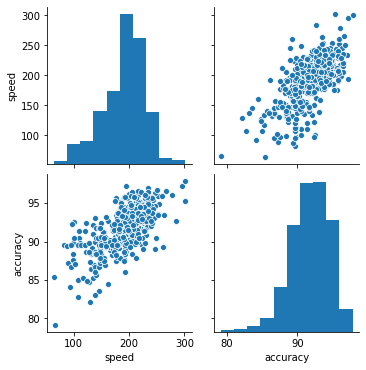

In [155]:
df = DataFrame({'speed': results, 'accuracy': accuracy, 'date': dates})
indexes = list()
a = df['speed'].mean() - 15
for i, item in enumerate(df['speed'][150:]):
    if item < a :
        indexes.append(i + 150)
df.drop(index=indexes, inplace=True)
df.index = range(len(df))
df['accuracy'] = df['accuracy'].astype(float)
sns.pairplot(data=df)
df.corr()

Как видно, скорость печати сильно зависит от точности

Text(0.5, 1.0, 'Статистика скорости печати Ratatype с (19 сен 20) по (07 ноя 20)')

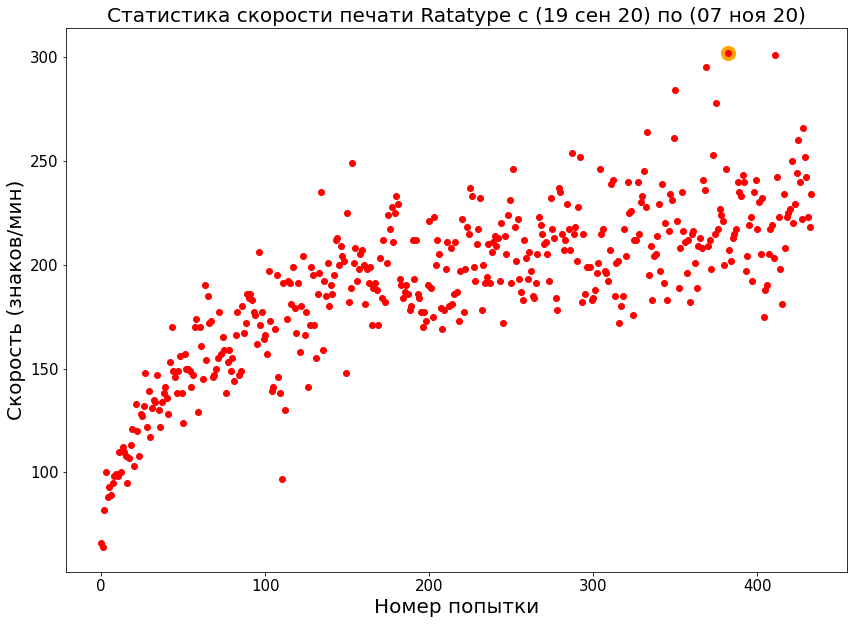

In [157]:
plt.figure(figsize=(14, 10))
plt.plot(df.index, df['speed'], 'ro')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Номер попытки", fontsize=20)
plt.ylabel("Скорость (знаков/мин)", fontsize=20)
record = max(list(df['speed'].values))
mask = list(np.abs(df['speed']) >= record)
plt.scatter(df.index[mask], df['speed'][mask], color='orange', s=200, marker='o')
plt.title(f"Статистика скорости печати Ratatype с ({dates[0]}) по ({dates[-1]})", fontsize=20)

Text(0.5, 1.0, 'Статистика точности печати Ratatype с (19 сен 20) по (07 ноя 20)')

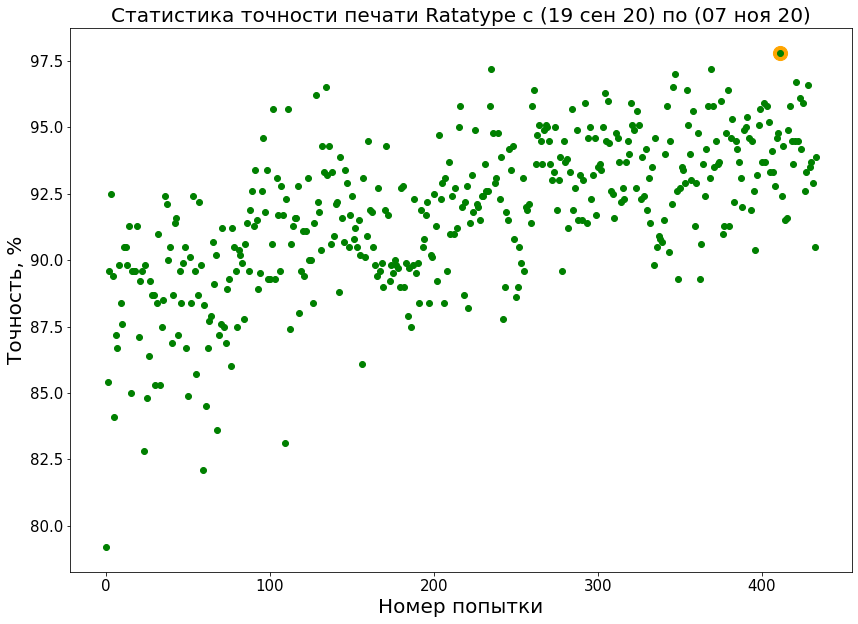

In [158]:
plt.figure(figsize=(14, 10))
plt.plot(df.index, df['accuracy'], 'go')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Номер попытки", fontsize=20)
plt.ylabel("Точность, %", fontsize=20)
record = max(list(df['accuracy'].values))
mask = list(np.abs(df['accuracy']) >= record)
plt.scatter(df.index[mask], df['accuracy'][mask], color='orange', s=200, marker='o')
plt.title(f"Статистика точности печати Ratatype с ({dates[0]}) по ({dates[-1]})", fontsize=20)

Построим две линейные модели: одну корневую, другую: логарифмическую

In [159]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn import linear_model
reg = linear_model.LinearRegression()
df["sqrt"] = [x**0.25 for x in df.index]
## так как ln(0) не определен:
df["log"] = [0.72*math.log(1.0*x + 0.5) for x in df.index]
Y = df["speed"]

Корень из среднеквдартичной ошибки (MSE), при использовании модели: y=x^(0.25) (y - скорость печатания,x -номер попытки) : 20.11119629354724


Text(0, 0.5, 'Скорость (знаков/мин)')

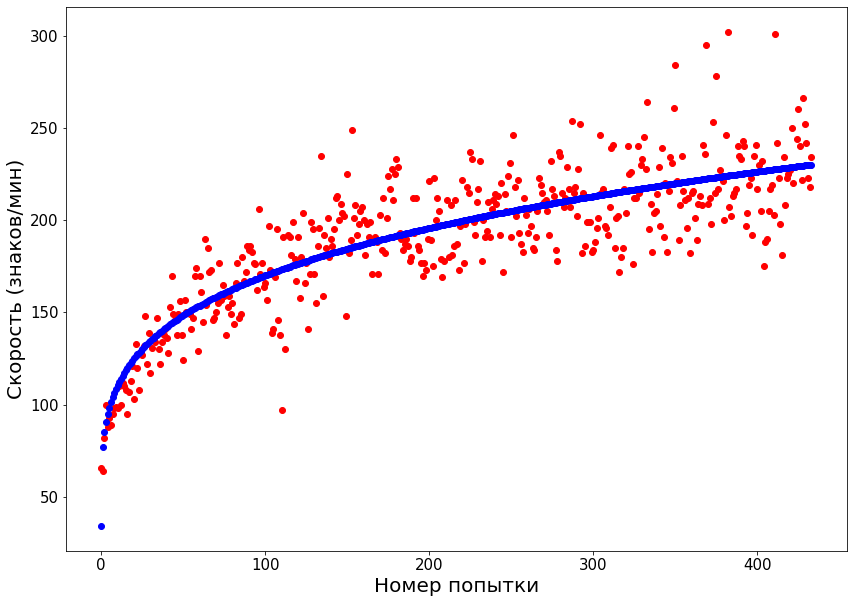

In [134]:
X1 = df[['sqrt']]
reg.fit(X1, Y)
plt.figure(figsize=(14, 10))
plt.plot(df.index, df['speed'], 'ro')
plt.plot(df.index, reg.predict(X), 'bo');
print(f"Корень из среднеквдартичной ошибки (MSE), при использовании модели: y=x^(0.25) (y - скорость печатания,"
      f"x -номер попытки) : {math.sqrt(mean_squared_error(Y, reg.predict(X)))}")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Номер попытки", fontsize=20)
plt.ylabel("Скорость (знаков/мин)", fontsize=20)

Корень из среднеквдартичной ошибки (MSE), при использовании модели: y = 0.7*ln(x + 1) (y - скорость печатания,x -номер попытки) : 20.190971474049267


Text(0, 0.5, 'Скорость (знаков/мин)')

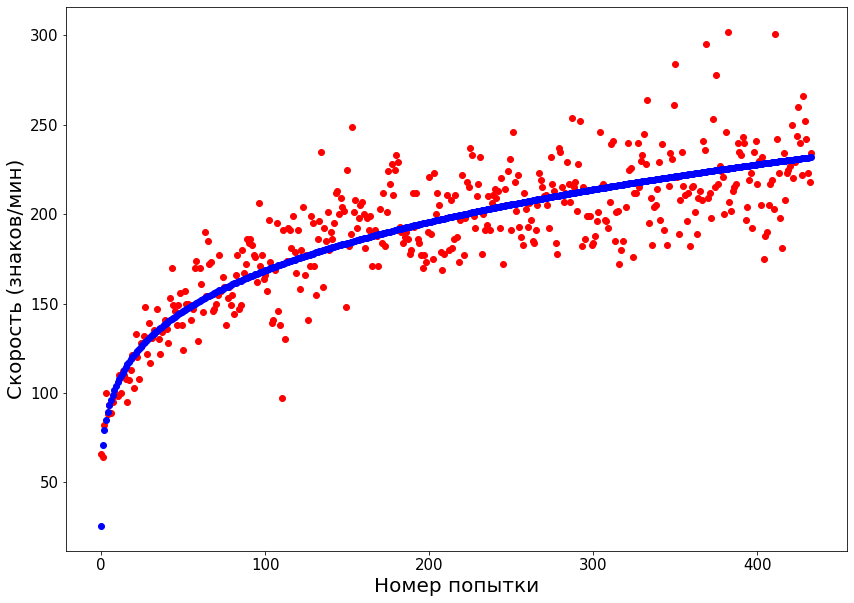

In [160]:
X2 = df[['log']]
reg.fit(X2, Y)
plt.figure(figsize=(14, 10))
plt.plot(df.index, df['speed'], 'ro')
plt.plot(df.index, reg.predict(X), 'bo');
print(f"Корень из среднеквдартичной ошибки (MSE), при использовании модели: y = 0.7*ln(x + 1) (y - скорость печатания,"
      f"x -номер попытки) : {math.sqrt(mean_squared_error(Y, reg.predict(X)))}")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Номер попытки", fontsize=20)
plt.ylabel("Скорость (знаков/мин)", fontsize=20)

Как видим, ошибка на обучающих данных практически одиноаква и немного меньше у модели корня из 0.25. Однако, как известно, корень растёт намного быстрее чем логарифм, и пострив следующие графики, мы убедимся, что несмотря, н

Text(0.5, 1.0, 'y = 0.7*ln(x + 1)')

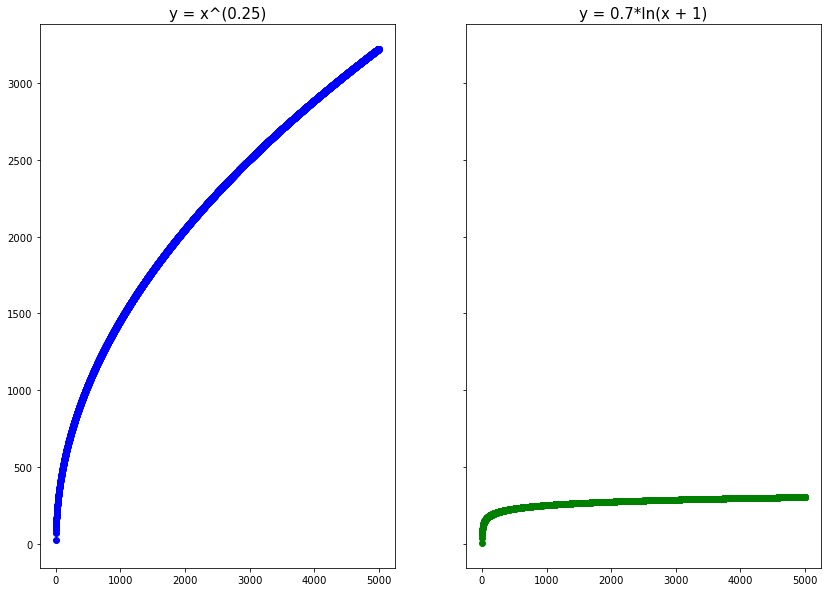

In [149]:
data = DataFrame({'total': np.arange(0, 5000, 1)})
data["sqrt"] = [x**0.5 for x in data.total]
data['log'] = [0.72*math.log(1.0*x + 0.5) for x in data.index]
Z1 = data[['sqrt']]
Z2 = data[['log']]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
ax1.plot(data[['total']], reg.predict(Z1), 'bo');
ax1.set_title("y = x^(0.25)", fontsize=15)
ax2.plot(data[['total']], reg.predict(Z2), 'go');
ax2.set_title("y = 0.7*ln(x + 1)", fontsize=15)